In [1]:
# import pylsl
%matplotlib qt5
%config Completer.use_jedi = False

import mne
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier

from scipy.signal import find_peaks

In [2]:
SAMPLING_FREQUENCY = 5000 #Hz
CHANNEL_NUMBER = 12
BANDPASS_LIMITS = (200, 1000)

In [3]:
def read_data(filename, show=True, event_id=[1, 2]):
    raw=mne.io.read_raw_brainvision(filename, preload=True)
    raw_hil = raw.copy().filter(BANDPASS_LIMITS[0], BANDPASS_LIMITS[1]).apply_hilbert(envelope=True).filter(0, 20)
    events=mne.events_from_annotations(raw_hil)[0]
    epochs = mne.Epochs(raw_hil, 
                        events=events, 
                        tmin=0, tmax=1.5, 
                        preload=True, 
                        baseline=None).apply_hilbert(envelope=True)
    if show:
        raw_hil.plot()
    return epochs

In [4]:
#Read all fingers
initial_stance = read_data('Data/NeoRec_2022-10-06_18-15-37.vhdr', show=True)
# Pointing_grip = read_data('Data/Pointing_grip.vhdr', show=True)
# Precise_grip = read_data('Data/Precise_grip.vhdr', show=True)
# Power_grip = read_data('Data/Power_grip.vhdr', show=True)
# Supination_pronation = read_data('Data/Supination_pronation.vhdr', show=False)
# Thumb_grip = read_data('Data/Thumb_grip.vhdr', show=False)
# Wrist_flexion_extension = read_data('Data/Wrist_flexion_extension.vhdr', show=False)

Extracting parameters from Data/NeoRec_2022-10-06_18-15-37.vhdr...
Setting channel info structure...
Reading 0 ... 397413  =      0.000 ...    79.483 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 331 samples (0.066 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pa

In [17]:
events

array([ 0.    ,  1.9196,  3.3486,  4.7386,  6.0376,  7.3476,  8.6536,
        9.9986, 11.2646, 12.5656, 13.9156, 15.2606, 16.5646, 17.8706,
       19.3366, 20.6446, 21.9906, 23.3746, 24.7616, 26.0686, 27.4526,
       28.7566, 30.1046, 31.4916, 32.8786, 34.1856, 35.4916, 36.8396,
       38.1816, 39.6116, 40.9556, 42.3416, 43.6444, 44.9926, 46.4216,
       47.7646, 49.2326, 50.6178, 52.0044, 53.3506, 54.8206, 56.2066,
       57.6336, 59.0246, 60.4526, 61.8836, 63.2246, 64.6546, 66.0426,
       67.4686, 68.8126, 70.1978, 71.5026, 72.9726, 74.3138, 75.7386])

Using matplotlib as 2D backend.


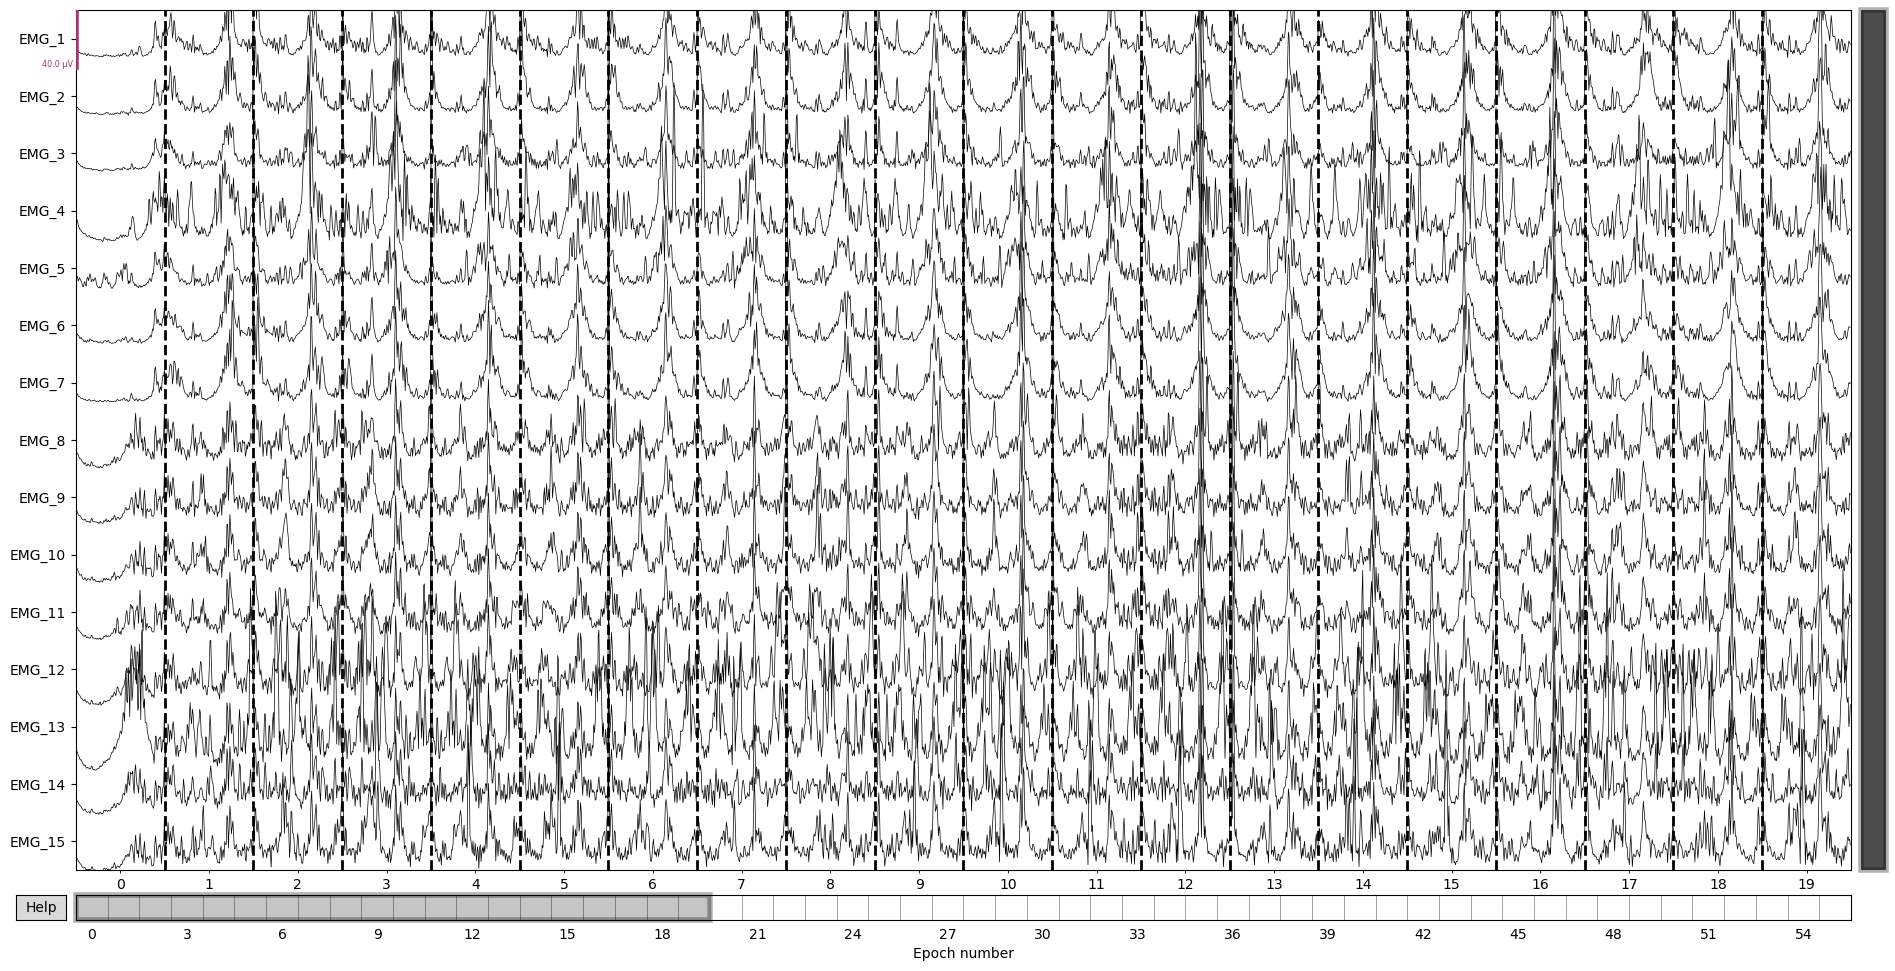

Dropped 0 epochs: 
Channels marked as bad: none


In [6]:
Elbow_flexion.plot()

In [33]:
def get_features_labels(epochs):
    X=[]
    for i in range(epochs._data.shape[0]):
        channel_names = np.arange(CHANNEL_NUMBER).astype(str).tolist()
        channel_types = ['emg']*CHANNEL_NUMBER
        info = mne.create_info(channel_names, SAMPLING_FREQUENCY, channel_types)
        raw = mne.io.RawArray(epochs._data[i], info, verbose=False)
        raw.filter(BANDPASS_LIMITS[0], BANDPASS_LIMITS[1], picks=['emg'], n_jobs=4)
        x__=[]
        # Mean absolute value
        for channel in raw.get_data():
            x__.append(channel.mean())
        # Matematical expactation
        for channel in raw.get_data():
            x__.append(channel.std())
        # Variance
        for channel in raw.get_data():
            x__.append(channel.var())
        # Waveform length
        for channel in raw.get_data():
            x__.append(np.sum(np.diff(channel, n=1)))
        # Number pf peaks
        for channel in raw.get_data():
            x__.append(len(find_peaks(channel)))
        
        # Append PCA of epoch data
        pca = PCA(6)
        pv = pca.fit_transform(epochs._data[i])
                         
        X.append(x__)
    X = np.array(X).squeeze()
    y = epochs.events[:,-1].flatten()
    return X, y

In [95]:
epochs=Wrist_flexion_extension
X=[]
FS=5000
Time=2
Wind=1
ch_num=12

for i in range(epochs._data.shape[0]):
    channel_names = np.arange(ch_num).astype(str).tolist()
    channel_types = ['eeg']*ch_num
    sfreq = FS
    info = mne.create_info(channel_names, sfreq, channel_types)
    raw = mne.io.RawArray(epochs._data[i], info, verbose=False)
    
    raw.filter(200, 1000)
    x__=raw.apply_hilbert(envelope=True).resample(10).get_data()
    x_=x__.flatten().reshape(1,-1)
    X.append(x_) 

In [34]:
X, y = get_features_labels(Elbow_flexion)
classifier = SVC(C=0.8, kernel='rbf', probability=True)
# cross_val_score(classifier, X, y, cv=3)
classifier.fit(X, y)
classifier.score(X, y)

0.6440677966101694

In [21]:
X = np.array(X)
X.shape

(59, 60)

In [102]:
X=np.array(X).squeeze()

In [104]:
X.shape

(45, 240)

In [15]:
y = epochs.events[:,-1].flatten()

NameError: name 'epochs' is not defined

In [107]:
epochs.events[:,-1].flatten()

array([99999, 10001, 10002, 10001, 10002, 10001, 10002, 10001, 10002,
       10001, 10002, 10001, 10002, 10001, 10002, 10001, 10002, 10001,
       10002, 10001, 10002, 10001, 10002, 10001, 10002, 10001, 10002,
       10001, 10002, 10001, 10002, 10001, 10002, 10001, 10002, 10001,
       10002, 10001, 10002, 10001, 10002, 10001, 10002, 10001, 10002])

In [85]:
y.shape

(45,)

In [22]:
pca = PCA(6)

pv = pca.fit_transform(X)
classifier = SVC(C=0.8, kernel='rbf', probability=True)

classifier.fit(pv, y)
yp = classifier.predict_proba(pv)

classifier.score(pv, y)#, roc_auc_score(y, yp, multi_class='ovr')

0.8305084745762712

In [115]:
fig = plt.figure()
plt.scatter(pv[:,0],pv[:,1],c=y)
plt.show()

In [32]:
pv.shape

(59, 6)

## Features extraction code
1. Time domain
    1. Mean absolute value
    1. STD
    1. Variance
    1. Waveform length!
    1. Number of peaks
2. Frequency domain
    2. Waveform length
    2. Mean frequecy
    2. Standard deviation of peaks
    2. Freqpvuency ratio
    2. Frequency energy


In [12]:
raw=mne.io.read_raw_brainvision('Data/NeoRec_2022-10-06_18-15-37.vhdr', preload=True).filter(200, 1000)
raw = raw.copy().filter(200, 1000)
events=mne.events_from_annotations(raw)[0]
epochs = mne.Epochs(raw, 
                    events=events, 
                    tmin=0, tmax=1.5, 
                    preload=True, 
                    baseline=None)

Extracting parameters from Data/NeoRec_2022-10-06_18-15-37.vhdr...
Setting channel info structure...
Reading 0 ... 397413  =      0.000 ...    79.483 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 331 samples (0.066 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window

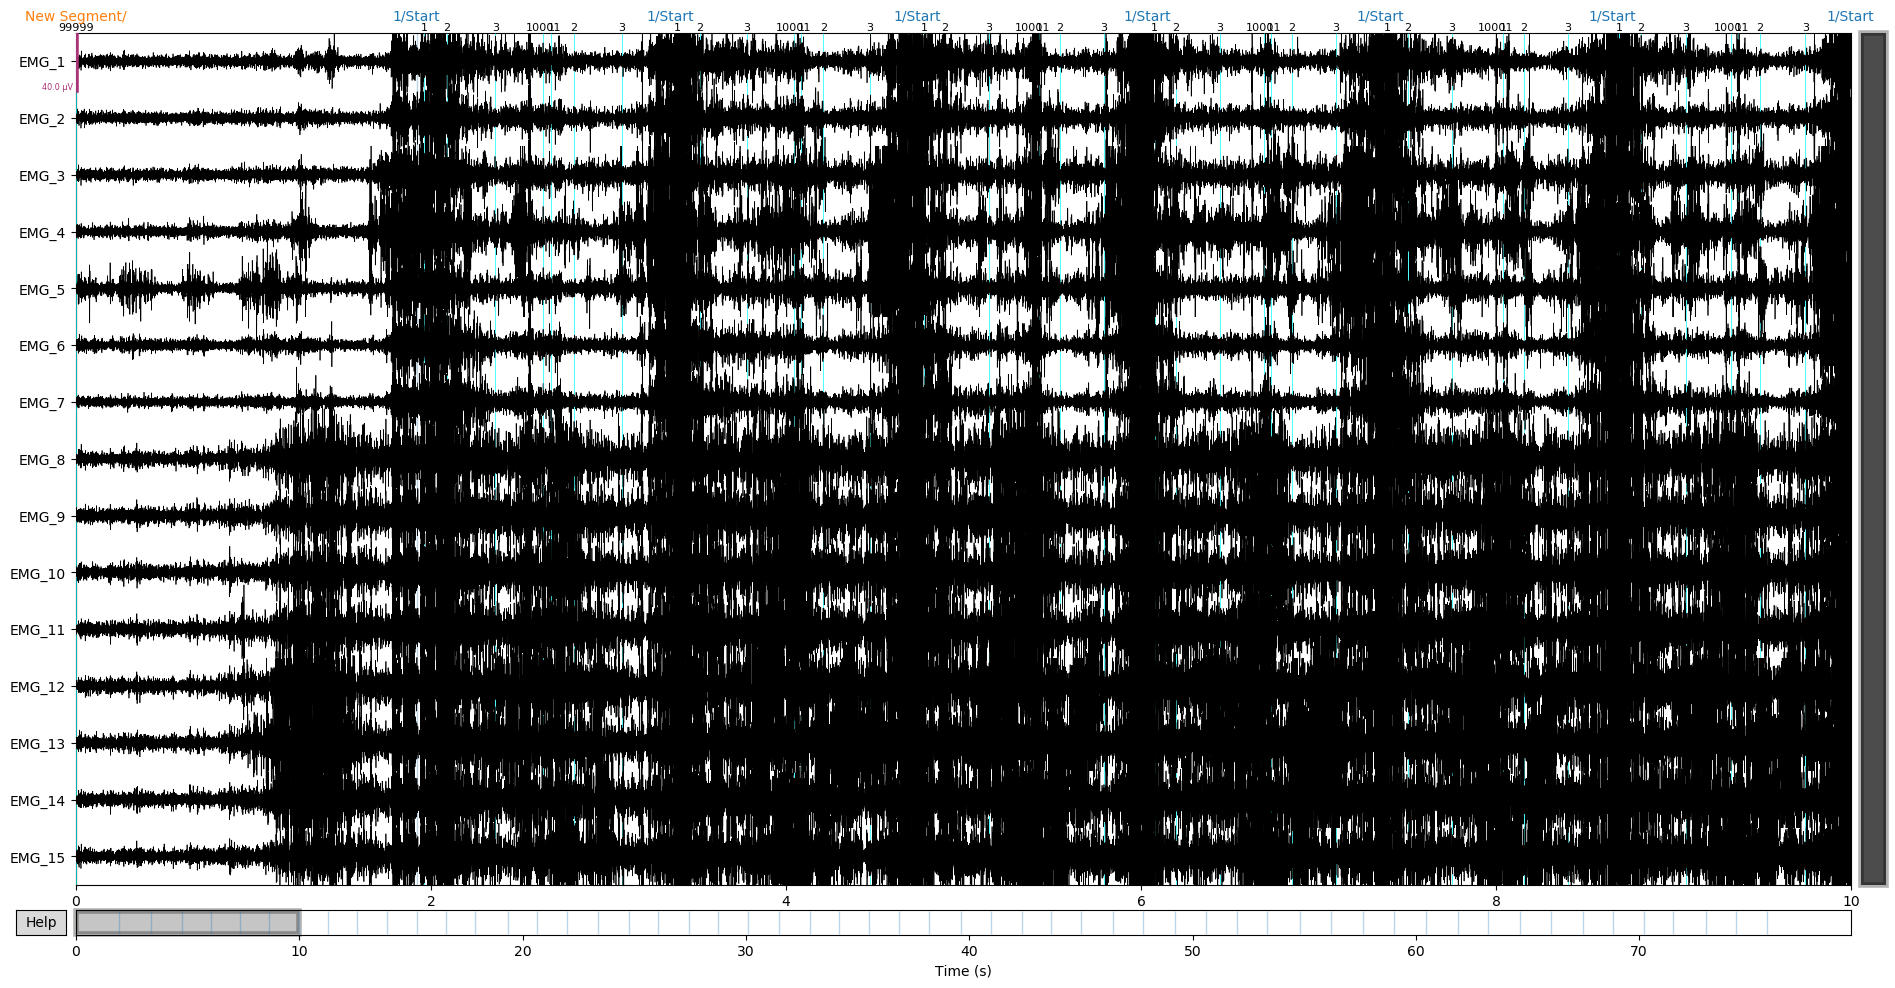

In [16]:
raw.plot(events=new_events)

In [14]:
new_events = [np.array([0, 0, 99999])]
for i in range(1, len(events) - 1):
    duration = events[i+1, 0] - events[i, 0]
    # new_events.append(events[i])
    new_events.append(np.array([int(events[i][0] +  duration * 0.03), 0, 1]))
    new_events.append(np.array([int(events[i][0] +  duration * 0.12), 0, 2]))
    new_events.append(np.array([int(events[i][0] +  duration * 0.31), 0, 3]))
    new_events.append(np.array([int(events[i][0] +  duration * 0.5), 0, 10001]))
    new_events.append(np.array([int(events[i][0] +  duration * 0.53), 0, 1]))
    new_events.append(np.array([int(events[i][0] +  duration * 0.62), 0, 2]))
    new_events.append(np.array([int(events[i][0] +  duration * 0.81), 0, 3]))
new_events = np.array(new_events)
    # new_events.append([new_events[i, 0] +  duration + 1])

In [18]:
epochs_initial = mne.Epochs(raw,
                    event_id=[10001],
                    events=new_events, 
                    tmin=0, tmax=1.5*0.19, 
                    preload=True, 
                    baseline=None)
epochs_loading = mne.Epochs(raw,
                    event_id=[1],
                    events=new_events, 
                    tmin=0, tmax=1.5*0.19, 
                    preload=True, 
                    baseline=None)
epochs_midstance = mne.Epochs(raw,
                    event_id=[2],
                    events=new_events, 
                    tmin=0, tmax=1.5*0.19, 
                    preload=True, 
                    baseline=None)
epochs_terminal = mne.Epochs(raw,
                    event_id=[3],
                    events=new_events, 
                    tmin=0, tmax=1.5*0.19, 
                    preload=True, 
                    baseline=None)

Not setting metadata
Not setting metadata
54 matching events found
No baseline correction applied
0 projection items activated
Loading data for 54 events and 1426 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
108 matching events found
No baseline correction applied
0 projection items activated
Loading data for 108 events and 1426 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
108 matching events found
No baseline correction applied
0 projection items activated
Loading data for 108 events and 1426 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
108 matching events found
No baseline correction applied
0 projection items activated
Loading data for 108 events and 1426 original time points ...
0 bad epochs dropped


In [19]:
epochs_initial

Number of events,54
Events,10001: 54
Time range,0.000 – 0.285 sec
Baseline,off


In [20]:
all_epochs = mne.concatenate_epochs([epochs_loading, epochs_midstance, epochs_terminal, epochs_initial], verbose=True)

Not setting metadata
Not setting metadata
378 matching events found
No baseline correction applied
0 bad epochs dropped


In [21]:
X=[]
FS=5000
Time=2
Wind=1
ch_num=15

for i in range(all_epochs._data.shape[0]):
    channel_names = np.arange(ch_num).astype(str).tolist()
    channel_types = ['eeg']*ch_num
    sfreq = FS
    info = mne.create_info(channel_names, sfreq, channel_types)
    raw = mne.io.RawArray(all_epochs._data[i], info, verbose=False)
    
    raw.filter(200, 1000)
    x__=raw.apply_hilbert(envelope=True).resample(10).get_data()
    x_=x__.flatten().reshape(1,-1)
    X.append(x_) 

In [22]:
X=np.array(X).squeeze()
y=all_epochs.events[:,-1].flatten()

In [23]:
pca = PCA(8)

pv = pca.fit_transform(X)
classifier = SVC(C=0.8, kernel='rbf', probability=True)

classifier.fit(pv, y)
yp = classifier.predict_proba(pv)

classifier.score(pv, y)#, roc_auc_score(y, yp, multi_class='ovr')

0.8783068783068783

In [25]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(classifier, pv, y, labels=)

c:\program files\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


In [196]:
epochs=all_epochs
X=[]
FS=5000
Time=2
Wind=1
ch_num=12

for i in range(epochs._data.shape[0]):
    channel_names = np.arange(ch_num).astype(str).tolist()
    channel_types = ['emg']*ch_num
    sfreq = FS
    info = mne.create_info(channel_names, sfreq, channel_types)
    raw = mne.io.RawArray(epochs._data[i], info, verbose=False)
    
    raw.filter(200, 1000, picks=['emg'])
    x__ = []
    # for channel in raw.get_data():
    #     x__.append(channel.mean())
    # for channel in raw.get_data():
    #     x__.append(channel.std())
    # for channel in raw.get_data():
    #     x__.append(channel.var())
    # pca = PCA(6)
    # pv = pca.fit_transform(epochs._data[i])
    # x__ = [*x__, *pv.flatten().tolist()]
    # x__=raw.apply_hilbert(envelope=True).resample(10).get_data()
    # x_=np.array(x__).flatten().reshape(1,-1)
    X.append(x__) 

In [197]:
X=np.array(X).squeeze()

In [198]:
X.shape

(57, 108)

In [199]:
y = epochs.events[:,-1].flatten()

In [216]:
svc = SVC(C=0.8, kernel='rbf', probability=True)
# classifier = RandomForestClassifier(bootstrap=True, max_depth=14, n_estimators=5, n_jobs=4)
dt = DecisionTreeClassifier(max_depth=10)
stacking_classifier = StackingClassifier([('svc', svc), ('dt', dt)])

stacking_classifier.fit(X, y)

c:\program files\python38\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\program files\python38\lib\site-packages\sklearn\model_selection\_validation.py:1093: RuntimeWarning: Number of classes in training fold (2) does not match total number of classes (3). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
c:\program files\python38\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\program files\python38\lib\site-packages\sklearn\model_selection\_validation.py:1093: RuntimeWarning: Number of classes in training fold (2) does not match total number of classes (3). Results may not be appropriate for your use case. To fix this, use a cross-validat

StackingClassifier(estimators=[('svc', SVC(C=0.8, probability=True)),
                               ('dt', DecisionTreeClassifier(max_depth=10))])

In [217]:
stacking_classifier.score(X, y)

0.7719298245614035

In [204]:
epochs=epochs
X=[]
FS=5000
Time=2
Wind=1
ch_num=12

for i in range(epochs._data.shape[0]):
    channel_names = np.arange(ch_num).astype(str).tolist()
    channel_types = ['eeg']*ch_num
    sfreq = FS
    info = mne.create_info(channel_names, sfreq, channel_types)
    raw = mne.io.RawArray(epochs._data[i], info, verbose=False)
    
    raw.filter(200, 1000)
    x__=raw.apply_hilbert(envelope=True).resample(10).get_data()
    x_=x__.flatten().reshape(1,-1)
    X.append(x_) 
X=np.array(X).squeeze()

In [219]:
cross_val_score(stacking_classifier, X, y, cv=3)

c:\program files\python38\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
c:\program files\python38\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\program files\python38\lib\site-packages\sklearn\model_selection\_validation.py:1093: RuntimeWarning: Number of classes in training fold (2) does not match total number of classes (3). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
c:\program files\python38\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\program files\python38\lib\site-packages\sklearn\model_selection\_valida

array([0.57894737, 0.42105263, 0.42105263])